# Aprendizaje por Q-Learning en MountainCar-v0
Este notebook implementa y analiza el aprendizaje por refuerzo usando Q-Learning en el entorno MountainCar-v0 de OpenAI Gymnasium.
Cada celda contiene comentarios detallados para facilitar la comprensión del proceso.

In [17]:
# Importar librerías y definir funciones auxiliares
from random import randint
import numpy as np
import gymnasium as gym

# Crear entorno sin renderizado por defecto
# Esto permite acceder a los límites del espacio de observación para discretizar
env = gym.make('MountainCar-v0')

# Discretización más fina y robusta para el espacio de observación
# Convierte el estado continuo en un estado discreto para usar en la Q-table
# Se usan 40 bins para cada dimensión (posición y velocidad)
def discretizar(valor):
    bins = 40
    aux = ((valor - env.observation_space.low) / (env.observation_space.high - env.observation_space.low)) * bins
    aux = np.clip(aux, 0, bins - 1)  # Asegura que los índices estén en rango
    return tuple(aux.astype(np.int32))

In [18]:
# Inicialización de la Q-table y parámetros de entrenamiento
# La Q-table almacena el valor esperado de cada acción en cada estado discreto
# Se inicializa con valores bajos para incentivar la exploración
q_table = np.random.uniform(low=-2, high=0, size=(40, 40, 3))

# Hiperparámetros del algoritmo Q-Learning
# tasa_aprendizaje: cuánto se actualiza la Q-table en cada paso
# factor_descuento: importancia de las recompensas futuras
# episodios: número total de episodios de entrenamiento
# listado_recompensas: almacena la recompensa total de cada episodio
# estados_visitados: almacena los estados visitados en todos los episodios

# Parámetros para la política epsilon-greedy
# epsilon: probabilidad de tomar una acción aleatoria (exploración)
# min_epsilon: valor mínimo de epsilon
# epsilon_decay: factor de decaimiento de epsilon por episodio

tasa_aprendizaje = 0.05
factor_descuento = 0.99
episodios = 5000
listado_recompensas = []
estados_visitados = []  # Lista para guardar los estados visitados
epsilon = 1.0  # Comienza con mucha exploración
min_epsilon = 0.01
epsilon_decay = 0.999

In [23]:
# Entrenamiento del agente Q-Learning
# En cada episodio, el agente interactúa con el entorno y actualiza la Q-table
# Se utiliza una política epsilon-greedy para balancear exploración y explotación
for episodio in range(episodios):
    # Renderiza el entorno solo en los últimos 10 episodios para visualizar el resultado
    render = episodio >= episodios - 10
    if render:
        env = gym.make('MountainCar-v0', render_mode='human')
    else:
        env = gym.make('MountainCar-v0')

    # Reinicia el entorno y discretiza el estado inicial
    estado_raw, _ = env.reset()
    estado = discretizar(estado_raw)
    final = False
    recompensa_total = 0

    # Ejecuta el episodio hasta que termine
    while not final:
        # Selecciona acción: con probabilidad epsilon explora, si no explota la Q-table
        if np.random.uniform(0, 1) < epsilon:
            accion = randint(0, 2)  # Explora (acción aleatoria)
        else:
            accion = np.argmax(q_table[estado])  # Explotar (mejor acción conocida)

        # Ejecuta la acción y observa el nuevo estado y recompensa
        nuevo_estado_raw, recompensa, terminado, truncado, _ = env.step(accion)
        nuevo_estado = discretizar(nuevo_estado_raw)
        estados_visitados.append(nuevo_estado)  # Guarda el estado visitado

        # Actualiza la Q-table usando la ecuación de Q-Learning
        q_table[estado][accion] += tasa_aprendizaje * (
            recompensa + factor_descuento * np.max(q_table[nuevo_estado]) - q_table[estado][accion])

        estado = nuevo_estado
        recompensa_total += recompensa
        final = terminado or truncado

    listado_recompensas.append(recompensa_total)

    # Decae epsilon para reducir la exploración con el tiempo
    if epsilon > min_epsilon:
        epsilon *= epsilon_decay
        epsilon = max(min_epsilon, epsilon)

    # Mostrar progreso cada 100 episodios y en los episodios con render
    if (episodio+1) % 100 == 0 or render:
        print(f"Episodio {episodio + 1} - Recompensa actual: {recompensa_total:.2f} - Recompensa promedio últimos 100: {np.mean(listado_recompensas[-100:]):.2f} - Epsilon: {epsilon:.3f}")

    env.close()

Episodio 100 - Recompensa actual: -200.00 - Recompensa promedio últimos 100: -200.00 - Epsilon: 0.905
Episodio 200 - Recompensa actual: -200.00 - Recompensa promedio últimos 100: -200.00 - Epsilon: 0.819
Episodio 200 - Recompensa actual: -200.00 - Recompensa promedio últimos 100: -200.00 - Epsilon: 0.819
Episodio 300 - Recompensa actual: -200.00 - Recompensa promedio últimos 100: -200.00 - Epsilon: 0.741
Episodio 300 - Recompensa actual: -200.00 - Recompensa promedio últimos 100: -200.00 - Epsilon: 0.741
Episodio 400 - Recompensa actual: -200.00 - Recompensa promedio últimos 100: -200.00 - Epsilon: 0.670
Episodio 400 - Recompensa actual: -200.00 - Recompensa promedio últimos 100: -200.00 - Epsilon: 0.670
Episodio 500 - Recompensa actual: -200.00 - Recompensa promedio últimos 100: -200.00 - Epsilon: 0.606
Episodio 500 - Recompensa actual: -200.00 - Recompensa promedio últimos 100: -200.00 - Epsilon: 0.606
Episodio 600 - Recompensa actual: -200.00 - Recompensa promedio últimos 100: -200.

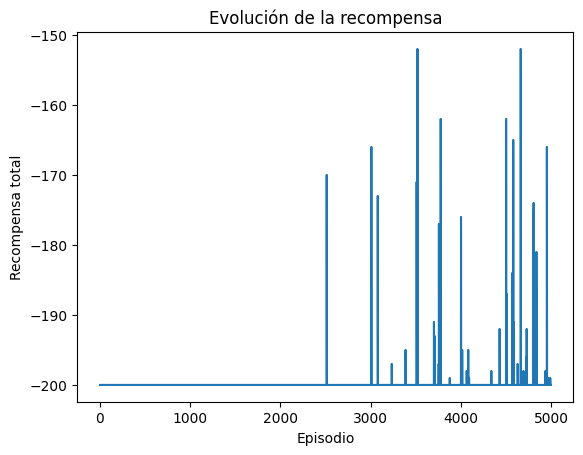

In [24]:
# Visualización de la evolución de la recompensa durante el entrenamiento
# Se grafica la recompensa total obtenida en cada episodio para analizar el aprendizaje
import matplotlib.pyplot as plt

plt.plot(listado_recompensas)
plt.xlabel("Episodio")
plt.ylabel("Recompensa total")
plt.title("Evolución de la recompensa")
plt.show()

In [25]:
# Visualización de los estados visitados en un DataFrame
# Se muestran los primeros estados visitados y el total de registros para análisis
import pandas as pd

df_estados = pd.DataFrame(estados_visitados, columns=["Posición", "Velocidad"])
display(df_estados.head())  # Muestra las primeras filas del DataFrame
print(f"Total de estados registrados: {len(df_estados)}")

,Posición,Velocidad
0,14,19
1,14,19
2,14,19
3,14,19
4,14,19


Total de estados registrados: 999371


In [26]:
# Análisis detallado de episodios, Q-table y mejores acciones
# Esta celda resume los resultados del entrenamiento, muestra los mejores episodios,
# la Q-table, las mejores acciones y los pasos del mejor episodio encontrado.
import numpy as np
import pandas as pd

# Guardar información de episodios y encontrar el mejor episodio
# Se reconstruye la cantidad de acciones y se identifica el episodio con mayor recompensa
episodios_info = []
mejor_reward = float('-inf')
mejor_indice = -1
mejor_pasos = []

i = 0
for ep, reward in enumerate(listado_recompensas):
    pasos = 0
    while i < len(estados_visitados):
        pasos += 1
        i += 1
        # Se asume máximo 200 pasos por episodio (ajustar si el entorno cambia)
        if pasos >= 200 or (ep < len(listado_recompensas)-1 and i >= (ep+1)*200):
            break
    episodios_info.append({'episodio': ep+1, 'acciones': pasos, 'reward': reward})
    if reward > mejor_reward:
        mejor_reward = reward
        mejor_indice = ep
        mejor_pasos = estados_visitados[i-pasos:i]

# Función para imprimir el resumen de resultados del entrenamiento
def print_process_info(episodios_info, mejor_indice, mejor_pasos):
    print('# Resumen de episodios')
    for info in episodios_info[:10]:
        print(f"EPISODIO {info['episodio']} - Numero de acciones: {info['acciones']} - Reward: {info['reward']}")
    print('\nMEJOR (ÚLTIMO) EPISODIO:')
    print(f"EPISODIO {mejor_indice+1}\n\tNumero de acciones: {episodios_info[mejor_indice]['acciones']}\n\tReward: {episodios_info[mejor_indice]['reward']}")
    print('\nQ_TABLE:')
    q_table_flat = q_table.reshape(-1, q_table.shape[-1])
    for idx, row in enumerate(q_table_flat[:16]):
        print(f"Estado {idx:2d}  " + "  ".join([f"{v:6.2f}" for v in row]))
    print('\nBEST Q_TABLE VALUES:')
    q_max = np.max(q_table, axis=2)
    df_qmax = pd.DataFrame(q_max[:4, :4], columns=[f"y{j}" for j in range(4)], index=[f"x{i}" for i in range(4)])
    print(df_qmax)
    print('\nBEST ACTIONS:')
    acciones = np.argmax(q_table, axis=2)
    acciones_map = {0: 'Izq', 1: 'Nada', 2: 'Der'}
    df_acc = pd.DataFrame([[acciones_map[a] for a in row[:4]] for row in acciones[:4]], columns=[f"y{j}" for j in range(4)], index=[f"x{i}" for i in range(4)])
    print(df_acc)
    print('\nPasos:')
    print(mejor_pasos)

# Llamada a la función de resumen para mostrar los resultados
print_process_info(episodios_info, mejor_indice, mejor_pasos)

# Resumen de episodios
EPISODIO 1 - Numero de acciones: 200 - Reward: -200.0
EPISODIO 2 - Numero de acciones: 200 - Reward: -200.0
EPISODIO 3 - Numero de acciones: 200 - Reward: -200.0
EPISODIO 4 - Numero de acciones: 200 - Reward: -200.0
EPISODIO 5 - Numero de acciones: 200 - Reward: -200.0
EPISODIO 6 - Numero de acciones: 200 - Reward: -200.0
EPISODIO 7 - Numero de acciones: 200 - Reward: -200.0
EPISODIO 8 - Numero de acciones: 200 - Reward: -200.0
EPISODIO 9 - Numero de acciones: 200 - Reward: -200.0
EPISODIO 10 - Numero de acciones: 200 - Reward: -200.0

MEJOR (ÚLTIMO) EPISODIO:
EPISODIO 3521
	Numero de acciones: 200
	Reward: -152.0

Q_TABLE:
Estado  0   -0.26   -0.48   -1.10
Estado  1   -1.68   -1.35   -1.78
Estado  2   -0.62   -0.97   -1.73
Estado  3   -0.64   -0.73   -1.43
Estado  4   -0.65   -1.22   -0.11
Estado  5   -1.19   -0.64   -0.04
Estado  6   -1.38   -0.05   -1.53
Estado  7   -1.77   -2.06   -1.83
Estado  8   -3.13   -3.55   -3.39
Estado  9   -8.53   -8.36   -8.38
Estad